## MNIST softmax regression

This notebook is based on the regular Tensorflow tutorial [MNIST For ML Beginners](https://www.tensorflow.org/versions/r1.1/get_started/mnist/beginners).

In [1]:
import os, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor
from helpers import read_mnist, tf_show_graph, output_folder
from random import randint

# render plots inline
%matplotlib inline
np.set_printoptions(threshold=np.nan) # dont ellide matrices
tf.logging.set_verbosity(tf.logging.WARN)

PLOT_SIZE = (16.9, 5.915)
mnist_path = 'C:/src/tf-playground/mnist'
tf_logs = output_folder(prefix='mnist_softmax_', folderpath=['logs'])
save_path = output_folder(prefix='mnist_softmax_', folderpath=['models'])

print('tf_logs: {}'.format(tf_logs))
print('save_path: {}'.format(save_path))

Instructions for updating:
Use the retry module or similar alternatives.
tf_logs: C:\src\tf-playground\logs\mnist_softmax_20180418145529
save_path: C:\src\tf-playground\models\mnist_softmax_20180418145529


Read data using mnist helper from tensorflow convinient tutorial namespace. 

In [2]:
mnist = read_mnist(mnist_path, one_hot=True)

Extracting C:/src/tf-playground/mnist\train-images-idx3-ubyte.gz
Extracting C:/src/tf-playground/mnist\train-labels-idx1-ubyte.gz
Extracting C:/src/tf-playground/mnist\t10k-images-idx3-ubyte.gz
Extracting C:/src/tf-playground/mnist\t10k-labels-idx1-ubyte.gz


### Model definition

Define the placeholders and variables (the model)

- `X` is a placeholder for the actual image data. By using `None` as the height dimension, Tensorflow is told that the height may variable (so `X` can be sized to include any number of images, in a batching style). Note that each row is a complete image, simply flattened out (27 * 27 = 784)
- `W` and `b` defines the weights and biases used by the model itself
- `Y` and `Y_` refers to our guesses and labels (correct guess value) respectively
- `cross_entropy` is a tensor that gives a measurement of how well we guessed correctly (aka loss)
- `train_step` is a operation that Tensorflow defines which seeks to mimize the `cross_entropy` tensor

Note that most of this if required for the training and evaluation phases. For actual predictions in deployment, `X` is the only input and `Y` the only output.

In [3]:
with tf.name_scope('Image'):
    X = tf.placeholder(tf.float32, [None, 784], 'X')
with tf.name_scope('Weight'):
    W = tf.Variable(tf.zeros([784, 10]), 'W')
with tf.name_scope('bias'):
    b = tf.Variable(tf.zeros([10]), 'b')

Y = tf.nn.softmax(tf.matmul(X, W) + b)
Y_ = tf.placeholder(tf.float32, [None, 10], 'Y_')

with tf.name_scope('loss'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_, logits=Y))
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
with tf.name_scope('correct_prediction'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer().run()
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(tf_logs, sess.graph)

Training loop

In [5]:
for i in range(2000):
    batch_xs, batch_ys = mnist.train.next_batch(100, shuffle=True)
    step_v, cross_entropy_v, acc_train = sess.run([train_step, cross_entropy, accuracy], feed_dict={X: batch_xs, Y_: batch_ys})
    if (i % 50 == 0):
        print('Step: {:04d}, loss: {}, acc: {}'.format(i, cross_entropy_v, acc_train))

Step: 0000, loss: 2.3025851249694824, acc: 0.07000000029802322
Step: 0050, loss: 1.8880113363265991, acc: 0.6899999976158142
Step: 0100, loss: 1.7336090803146362, acc: 0.7899999618530273
Step: 0150, loss: 1.7596380710601807, acc: 0.7699999809265137
Step: 0200, loss: 1.6907566785812378, acc: 0.8100000023841858
Step: 0250, loss: 1.644513487815857, acc: 0.9099999666213989
Step: 0300, loss: 1.6100167036056519, acc: 0.9199999570846558
Step: 0350, loss: 1.5870938301086426, acc: 0.9099999666213989
Step: 0400, loss: 1.5912470817565918, acc: 0.9199999570846558
Step: 0450, loss: 1.6119534969329834, acc: 0.9099999666213989
Step: 0500, loss: 1.663843035697937, acc: 0.8199999928474426
Step: 0550, loss: 1.598090648651123, acc: 0.9099999666213989
Step: 0600, loss: 1.5932505130767822, acc: 0.9199999570846558
Step: 0650, loss: 1.5793849229812622, acc: 0.9099999666213989
Step: 0700, loss: 1.5771124362945557, acc: 0.9099999666213989
Step: 0750, loss: 1.6011121273040771, acc: 0.8899999856948853
Step: 0800

### Testing the trained model

Now the model has been trained, and we verify the accuracy of the resultant weights and biases against the test set.

In [6]:
acc_test = sess.run(accuracy, feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
print('Test acc: {}'.format(acc_test))

Test acc: 0.9148000478744507


### `W` visualization
Evaluate the tensorflow variable to obtain a numpy matrix of actual weights for each class. To visualize the individual class weights, we first split `We` by columns, and then reshape into 28 x 28 individual numpy matrices.

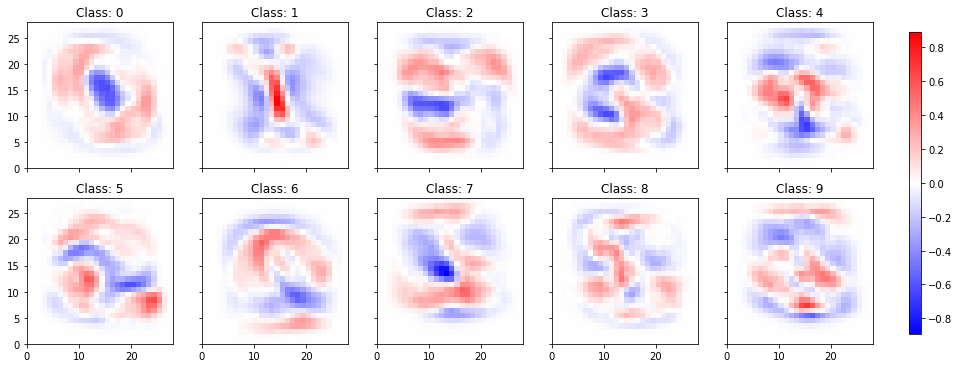

In [7]:
We = W.eval()
Wec = [(np.reshape(x, (28, 28))) for x in np.hsplit(We, 10)]
titles = ['Class: {}'.format(n) for n in range(10)]
vmin = min([m.min() for m in Wec])
vmax = max([m.max() for m in Wec])
# ensure the mean is 0, otherwise the base/neutral is non-white
vminmax = max(abs(vmin), vmax)

# create subplots
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True, figsize=PLOT_SIZE)
for index, (image, title) in enumerate(zip(Wec, titles)):
    (row, col) = (math.floor(index / 5), index % 5)
    ax[row, col].title.set_text(title)
    im = ax[row, col].pcolor(image, cmap='bwr', vmin=-vminmax, vmax=vminmax)
    ax[row, col].set(aspect=1)

fig.subplots_adjust(right=0.82) # adjust for colorbar
cbar_ax = fig.add_axes([0.85, 0.148, 0.01, 0.71])
fig.colorbar(im, cax=cbar_ax, cmap='bwr')
plt.show()

# dump graph itself
# tf_show_graph(tf)

### Deployment proof of concept

The `simple_save` function yields a quick way to persist your session. "Deployment" then means using the handy `predictor` to load the session from disk and return a "predictor" function. As stated previously, we only care about `W` and `Y` for actual use.

In [8]:
tf.saved_model.simple_save(sess, save_path, inputs={'X': X}, outputs={'Y': Y})
mnist_predictor = predictor.from_saved_model(save_path)

Pick one of the test images and try to predict it's label. Note some minor artifacts from training remains, such as `Y` and `W` being a vector of vectors due to the batching approach.

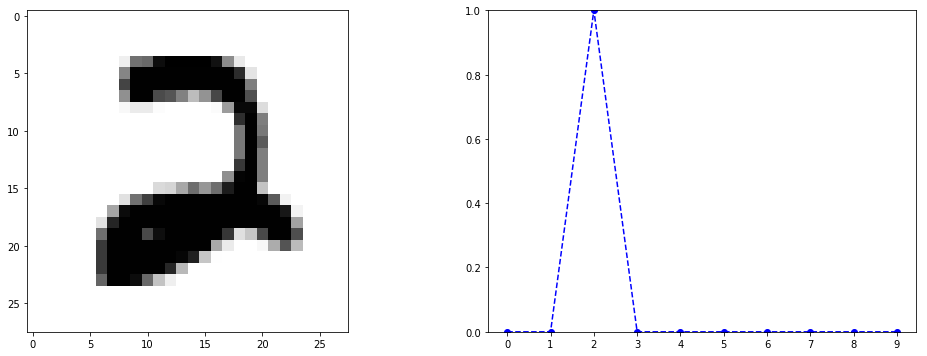

Guess  => 2
Actual => 2
Confidence 1.0, test img nr 8793


In [9]:
# a couple of tricky images that might misclassify:
# 613, 1107, 4177, 4724, 4837, 7637, 8325, 8639, 9010
img_idx = randint(0, len(mnist.test.labels))
lbl1 = mnist.test.labels[img_idx,:]
img1 = np.array([mnist.test.images[img_idx,:]])

predictions = mnist_predictor({'X': img1})
Y_val = predictions['Y'][0]
lbl_val = np.argmax(lbl1)
lbl_gss = np.argmax(Y_val)

fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize=PLOT_SIZE)
ax[0].imshow(img1.reshape(28, 28), cmap='gray_r')
ax[1].plot(Y_val, linestyle='--', marker='o', color='b')
ax[1].set_ylim(0, 1)
ax[1].set_xticks(range(0, 10))
plt.show()

print('Guess  => {}'.format(lbl_gss))
print('Actual => {}'.format(lbl_val))
print('Confidence {}, test img nr {}'.format(Y_val[lbl_gss], img_idx))